In [1]:
import torch
from torch import nn
import cv2
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import random
import numpy as np


# Model loading

In [2]:
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ResNet50Classifier, self).__init__()
        if pretrained:
            self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        else:
            self.backbone = models.resnet50(weights=None)
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

num_classes = 2
img_size = 224
base_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])
model = ResNet50Classifier(num_classes=num_classes, pretrained=False)
model.to(device)
checkpoint = torch.load("cifake_resNet_98.45.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()



Using cuda device


ResNet50Classifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

# Infer demo

In [4]:
def infer_image(file_path):
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)

    transformed_image = base_transform(image).unsqueeze(0)
    transformed_image = transformed_image.to(device)

    with torch.no_grad():
        outputs = model(transformed_image)
        probabilities = F.softmax(outputs, dim=1)
        real_probability = probabilities[0][1].item()
        fake_probability = probabilities[0][0].item()

    return {
        "fake_probability": fake_probability, 
        "real_probability": real_probability,
        "predicted_label": "REAL" if real_probability > fake_probability else "FAKE",
        "confidence": max(real_probability, fake_probability)
    }

In [5]:
def get_sample_images(num_samples=6):
    fake_dir = "cifake/test/FAKE"
    real_dir = "cifake/test/REAL"
    
    #for each label get num_samples//2 images -> for balance
    fake_images = random.sample(os.listdir(fake_dir), num_samples//2)
    real_images = random.sample(os.listdir(real_dir), num_samples//2)
    
    sample_images = []
    for img in fake_images:
        sample_images.append({
            'path': os.path.join(fake_dir, img),
            'true_label': 'FAKE'
        })
    for img in real_images:
        sample_images.append({
            'path': os.path.join(real_dir, img),
            'true_label': 'REAL'
        })
    
    return sample_images

sample_images = get_sample_images(6)

Image 1: 877 (9).jpg
  True Label: FAKE
  Predicted: FAKE
  Fake Prob: 0.999
  Real Prob: 0.001
  Correct: ✓
----------------------------------------
Image 2: 37 (4).jpg
  True Label: FAKE
  Predicted: FAKE
  Fake Prob: 1.000
  Real Prob: 0.000
  Correct: ✓
----------------------------------------
Image 3: 322 (5).jpg
  True Label: FAKE
  Predicted: FAKE
  Fake Prob: 1.000
  Real Prob: 0.000
  Correct: ✓
----------------------------------------
Image 4: 0674 (7).jpg
  True Label: REAL
  Predicted: REAL
  Fake Prob: 0.000
  Real Prob: 1.000
  Correct: ✓
----------------------------------------
Image 5: 0325 (2).jpg
  True Label: REAL
  Predicted: REAL
  Fake Prob: 0.000
  Real Prob: 1.000
  Correct: ✓
----------------------------------------
Image 6: 0741.jpg
  True Label: REAL
  Predicted: REAL
  Fake Prob: 0.000
  Real Prob: 1.000
  Correct: ✓
----------------------------------------


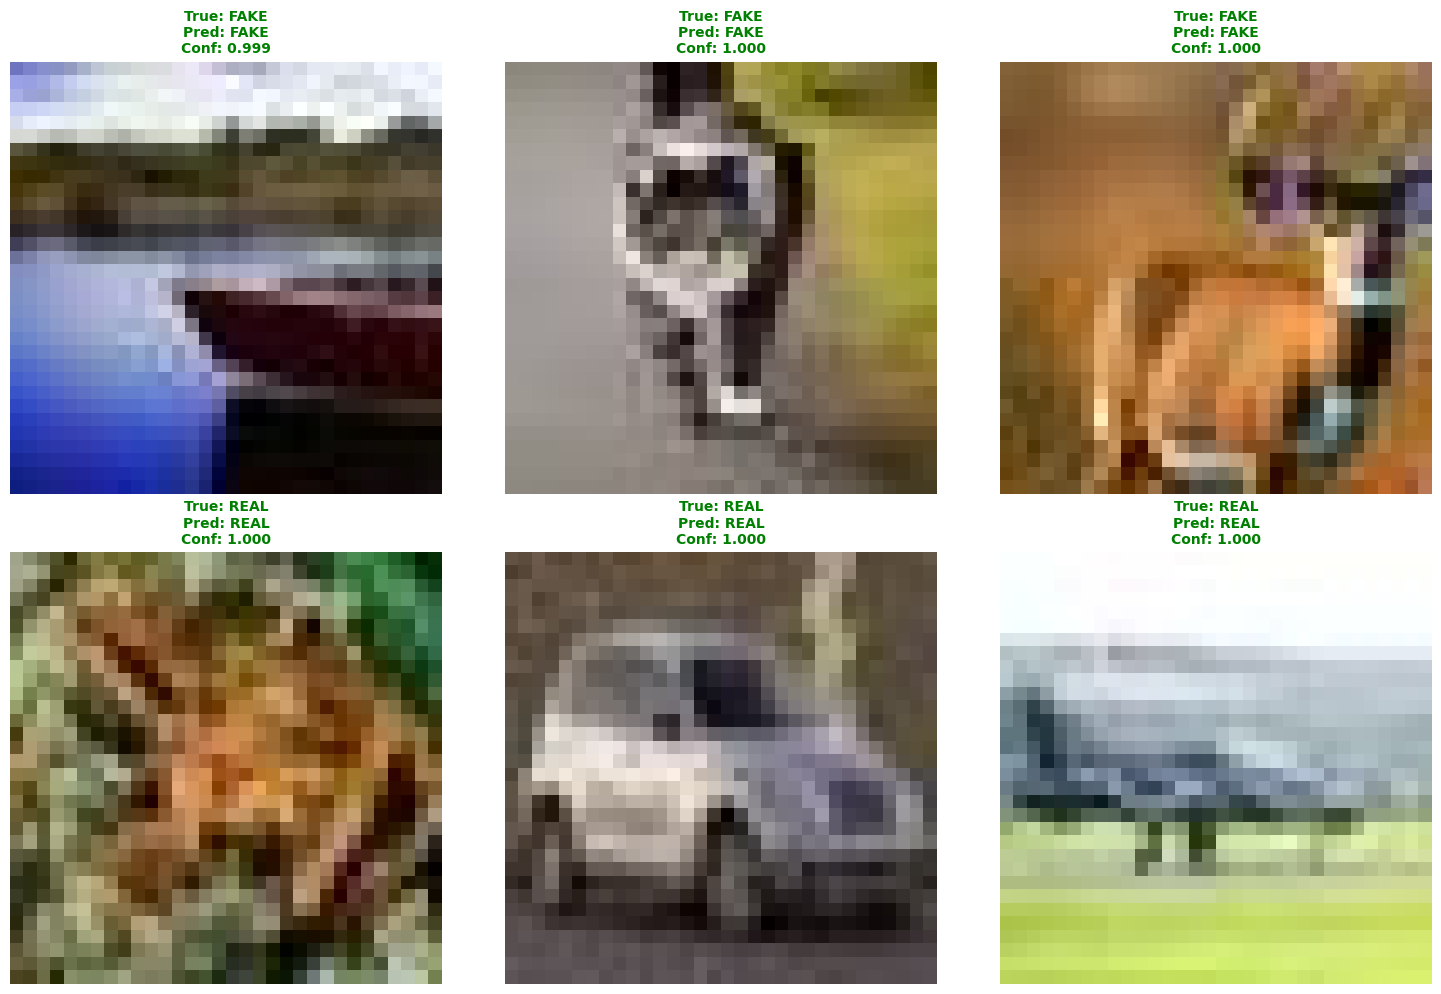

In [6]:
def display_predictions(sample_images):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, img_info in enumerate(sample_images):
        image = cv2.imread(img_info['path'])
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        result = infer_image(img_info['path'])

        axes[i].imshow(image_rgb)
        axes[i].axis('off')
        
        true_label = img_info['true_label']
        pred_label = result['predicted_label']
        confidence = result['confidence']
        
        color = 'green' if true_label == pred_label else 'red'
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}"
        axes[i].set_title(title, fontsize=10, color=color, weight='bold')
    plt.tight_layout()
    plt.show()

display_predictions(sample_images)

In [7]:
def calculate_sample_accuracy(sample_images):
    correct = 0
    total = len(sample_images)
    
    for img_info in sample_images:
        result = infer_image(img_info['path'])
        if img_info['true_label'] == result['predicted_label']:
            correct += 1
    
    accuracy = correct / total * 100
    print(f"\nSample Accuracy: {correct}/{total} = {accuracy:.2f}%")
    return accuracy


sample_accuracy = calculate_sample_accuracy(sample_images)




Sample Accuracy: 6/6 = 100.00%
